<a href="https://colab.research.google.com/github/abhishekshakya/seq-2-seq-for-neural-machine-translation-english-to-hindi-/blob/master/machineTranslation(attention).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/parallelCorpus/data.csv' 'data.csv'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('data.csv')
df.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [3]:
df.drop(columns=['source'],inplace=True)

In [4]:
df = df.iloc[:10000,:]
df.head()

,english_sentence,hindi_sentence
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [5]:
def cleanerEng(x):
  x = str(x)
  x = x.lower()
  x = re.sub(r'[^a-z0-9]+',' ',x)
  if len(x) > 150:
    x = x[:150]
  return x

def cleanerHindi(x):
  x = str(x)
  x = re.sub(r'[-.।|,?;:<>&$₹]+',' ',x)
  if len(x) > 150:
    x = x[:150]
  return x

In [6]:
df.iloc[:,0] = df['english_sentence'].apply(func=cleanerEng)
df.iloc[:,1] = df['hindi_sentence'].apply(func= cleanerHindi)
df.iloc[:,0] = df['english_sentence'].apply(func= lambda x : (str(x).split()))
df.iloc[:,1] = df['hindi_sentence'].apply(func= lambda x : (str(x).split()))

In [7]:
def addTokens(x,start=False):
  x.append('<END>')
  if start:
    x.insert(0,'<START>')
  return list(x)

In [8]:
df.iloc[:,0] = df['english_sentence'].apply(func= addTokens,start=False)
df.iloc[:,1] = df['hindi_sentence'].apply(func= addTokens,start=True)

In [9]:
df.iloc[79,1]

['<START>',
 'जो',
 'वह',
 'सीखता',
 'है',
 'या',
 'पूर्व',
 'क्रमादेशित',
 'होता',
 'है',
 '<END>']

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

In [11]:
data = df.values

In [12]:
data[:,1].shape

(10000,)

In [13]:
class vocab:

  def __init__(self,data,token=True):
    self.data = data
    if token:
      self.word2idx = {'<START>':1, '<END>':2, '<PAD>':0}
      self.idx2word = {1:'<START>', 2:'<END>', 0:'<PAD>'}
      self.idx = 2

    else:
      self.word2idx = {'<PAD>':0, '<END>':1}
      self.idx2word = {0:'<PAD>', 1:'<END>'}
      self.idx = 1

    self.x = []
    self.create()
    self.vocab_size = self.idx + 1

  def create(self):
    max_len = 0;
    for sentence in  self.data:
      max_len = max(max_len, len(sentence))
      for word in sentence:
        if self.word2idx.get(word) is None:
          self.idx += 1
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
    
    for sentence in self.data:
      sent = []
      for word in sentence:
        sent.append(self.word2idx[word])
      
      for i in range(len(sentence),max_len+1):
        sent.append(0)
      
      self.x.append(torch.Tensor(sent))

    

In [14]:
English_vocab = vocab(data[:,0],token=False)
Hindi_vocab = vocab(data[:,1],token=True)

In [15]:
for idx in Hindi_vocab.x[2]:
  print(Hindi_vocab.idx2word[int(idx)],end=' ')

<START> यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

In [16]:
class parallelData(Dataset):

  def __init__(self):
    self.x = English_vocab.x
    self.y = Hindi_vocab.x

  def __getitem__(self,i):
    return self.x[i], self.y[i]
  
  def __len__(self):
    return len(self.x)


In [17]:
dataset = parallelData()

In [18]:
a = dataset[0][0].shape[0]
b = dataset[0][1].shape[0]
for i in range(len(dataset)):
  if a != dataset[i][0].shape[0] or b != dataset[i][1].shape[0]:
    print(a,dataset[i][0].shape[0],b,dataset[i][1].shape[0])

In [19]:
Hindi_vocab.x[90].shape

torch.Size([42])

In [20]:
torch.cuda.device_count()

1

In [21]:
#Model preparation

class encoder(nn.Module):

  def __init__(self, input_size, embedding_size, hidden_size, layers, bidirectional):
    '''
    input_size = size of vocab
    embedding_size = embedding dim
    hidden_size = hidden state size
    layer = num of layers of lstms
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True, bidirectional = bidirectional)
    self.bidirectional = bidirectional
    #in order to convert bidirectional hidden state to unidirectional if LSTM is bidirectional 
    self.fc_hidden = nn.Linear(hidden_size*2, hidden_size)
    self.fc_cell = nn.Linear(hidden_size*2, hidden_size)

  def forward(self,x):
    '''
    x shape = [batch_size, sentence]
    one complete sentence represents a "sequence"
    '''
    x = self.embed(x) # shape [batch_size,  sentence, embed_size]
    output, (hidden_state, cell_state) = self.lstm(x) #shape [batch_size, seq_len, num_directions(2)*hidden_size]

    if self.bidirectional:  #since we have 2 directions so add(concat) hidden of both directions into one
      hidden = torch.cat((hidden_state[0:1], hidden_state[1:2]), dim=2)
      cell = torch.cat((cell_state[0:1], cell_state[1:2]), dim = 2) #output [1(layer), batch, hidden_size*2]
      hidden_state = self.fc_hidden(hidden)
      cell_state = self.fc_cell(cell)

    # print(output.shape, x.shape)
    #output shape = [batch_size, seq_len, 2*hidden_size] 
    #hidden shape =[1(layers), batch_size, hidden_size]
    return output, hidden_state, cell_state

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
class decoder(nn.Module):

  def __init__(self,input_size, embedding_size, hidden_size, layers):
    '''
    same configuration as encoder
    here input_size = size of hindi vocab
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among hindi vocab therefore out_feature=input_size

  def forward(self,x,hidden_state, cell_state):
    '''
    to have control over output we have to take sentence as word by word
    therefore seq_len would be 1 as input is  one word not the whole sentence
    x = [batch_size] ->required-> [batch_size, 1] (1 is seq_len)
    '''
    # print(x.shape)
    x = x.reshape(-1,1) # shape [batch, 1]
    # print(x.shape)
    x = self.embed(x) # shape [batch, 1, embed_dim]

    output, (hidden_state, cell_state) = self.lstm(x, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, hindi_vocab_size]
    
    #just for removing extra dim
    output = output.squeeze(dim=1) #shape [batch, hindi_vocab_size]

    return output, hidden_state, cell_state


##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class AttnDecoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, layers):
    super().__init__()

    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=hidden_size*2 + embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among hindi vocab therefore out_feature=input_size

    #encoder_states from encoder => [batch, seq_len(35), 2*hidden_size]
    #prev decoder hidden_state => [batch, layers(1)*directions(2), hidden_size] =>need to be in => [batch, seq(35), hidden_size]
    #therefore input of energy will be along hidden_size ie input = hidden_size*2
    self.energy =  nn.Linear(hidden_size*3, 1) #out [batch, seq_len, 1] (2 hidden state from bidirectional encoder and 1 from prev decoder hidden state => 1+2= 3 hidden states as input)
    self.softmax = nn.Softmax(dim=1)# doing softmax for each word ie (dim=1)

  
  def forward(self, x, hidden_state, cell_state, encoder_states):
    # print(encoder_states.shape)
    seq_len = encoder_states.shape[1]
    batch_size = encoder_states.shape[0]
    hidden_size = encoder_states.shape[2]

    h_new = hidden_state.repeat(seq_len, 1, 1) #shape [seq_len*1, batch, hidden_size*2(bidirectional)] it will repeat dim=0 seq length times
    #by doing .repeat operation we can concat hidden state with all timestamps of encoder_states
    # print(h_new.shape, encoder_states.shape, hidden_state.shape)
    h_new = h_new.permute(1,0,2) #[batch, seq_len, hidden_size*2]
    energy = self.energy(torch.cat((h_new, encoder_states), dim=2))#input [batch, seq_len(35), hidden_size*3]  out = [batch, seq_len(35), 1]
    att_weights = self.softmax(energy)
    att_weights = att_weights.permute(0,2,1) # [batch, 1, seq_len]

    context = torch.bmm(att_weights, encoder_states) #[batch, 1, hidden_size*2]
    

    x = x.reshape(-1,1) # shape [batch, 1]
    x = self.embed(x) # shape [batch, 1, embed_dim]

    input_new = torch.cat((context, x), dim=2) #[batch, 1, hidden_size*2 +embed_dim]

    output, (hidden_state, cell_state) = self.lstm(input_new, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, hindi_vocab_size]

    output = output.squeeze(dim=1) #shape [batch, hindi_vocab_size]
    del h_new
    del context
    del input_new
    return output, hidden_state, cell_state

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class seq2seq(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder


  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of english sentences[batch, sentece(padded)]
    target = batch of hindi sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    hindi_vocab_size = Hindi_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, hindi_vocab_size)).to(device)

    _, hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token

    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]

      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    
    return output  #shape[seq_len, batch_size, vocab_size]

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class Attnseq2seq(nn.Module):
  def __init__(self, encoder, att_decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = att_decoder


  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of english sentences[batch, sentece(padded)]
    target = batch of hindi sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    hindi_vocab_size = Hindi_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, hindi_vocab_size)).to(device)

    encoder_states, hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token

    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]

      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    
    return output  #shape[seq_len, batch_size, vocab_size]



In [22]:
##training
epochs = 120
learning_rate = 0.0006
batch_size = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_size = 256
hidden_size = 256
layers = 1
bidirection = True


In [23]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [24]:
it = iter(loader)
x,y = next(it)
print(x.shape,y.shape)
len(dataset)


torch.Size([100, 37]) torch.Size([100, 42])


10000

In [26]:
ENC = encoder(English_vocab.vocab_size, embedding_size, hidden_size, layers, bidirection).to(device)
# DE = decoder(Hindi_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
DE = AttnDecoder(Hindi_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
# model = seq2seq(ENC,DE).to(device)
model = Attnseq2seq(ENC,DE).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)


In [27]:
train_loss = []
for epoch in tqdm(range(epochs)):
  for id,(x,y) in (enumerate(tqdm(loader))):
    x = x.long().to(device)
    y = y.long().to(device)#[batch,seq]

    output = model(x,y,1)# [seq, batch, vocab]
    output = output[1:].reshape(-1,output.shape[2])
    y = y.permute(1,0)#[seq, batch]
    y = y[1:].reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output,y)

    loss.backward()
    optimizer.step()

    # if id%20 == 0:
  print(f'[{epoch+1}/{epochs}] loss=>{loss.item()}')
  train_loss.append(loss.item())

  


[1/120] loss=>7.330247402191162



[2/120] loss=>7.126391410827637



[3/120] loss=>6.718351364135742



[4/120] loss=>6.6905999183654785



[5/120] loss=>6.452012538909912



[6/120] loss=>6.4064860343933105



[7/120] loss=>6.1238627433776855



[8/120] loss=>5.964419841766357



[9/120] loss=>5.990975379943848



[10/120] loss=>5.776092052459717



[11/120] loss=>5.686622619628906



[12/120] loss=>5.59915828704834



[13/120] loss=>5.30171012878418



[14/120] loss=>5.306375980377197



[15/120] loss=>5.178899765014648



[16/120] loss=>5.063439846038818



[17/120] loss=>4.90515661239624



[18/120] loss=>4.666688442230225



[19/120] loss=>4.5143609046936035



[20/120] loss=>4.554381847381592



[21/120] loss=>4.381796360015869



[22/120] loss=>4.351853847503662



[23/120] loss=>4.106031894683838



[24/120] loss=>4.101764678955078



[25/120] loss=>3.791531801223755



[26/120] loss=>3.7445597648620605



[27/120] loss=>3.6674115657806396



[28/120] loss=>3.632824659347534



[29/120] loss=>3.308244228363037



[30/120] loss=>3.3344404697418213



[31/120] loss=>3.2107043266296387



[32/120] loss=>3.0955827236175537



[33/120] loss=>2.9641335010528564



[34/120] loss=>2.8664872646331787



[35/120] loss=>2.773742914199829



[36/120] loss=>2.6344058513641357



[37/120] loss=>2.619271993637085



[38/120] loss=>2.4772613048553467



[39/120] loss=>2.278256416320801



[40/120] loss=>2.2035608291625977



[41/120] loss=>2.1667728424072266



[42/120] loss=>2.192333936691284



[43/120] loss=>1.9456440210342407



[44/120] loss=>1.9524176120758057



[45/120] loss=>1.921888828277588



[46/120] loss=>1.8186179399490356



[47/120] loss=>1.7338154315948486



[48/120] loss=>1.6422224044799805



[49/120] loss=>1.563103437423706



[50/120] loss=>1.567525029182434



[51/120] loss=>1.428048014640808



[52/120] loss=>1.3673229217529297



[53/120] loss=>1.1999363899230957



[54/120] loss=>1.263407588005066



[55/120] loss=>1.1738765239715576



[56/120] loss=>1.1306817531585693



[57/120] loss=>1.1086112260818481



[58/120] loss=>1.0176268815994263



[59/120] loss=>0.9848265051841736



[60/120] loss=>0.8968560695648193



[61/120] loss=>0.8772664070129395



[62/120] loss=>0.8800609707832336



[63/120] loss=>0.7561132907867432



[64/120] loss=>0.7878068089485168



[65/120] loss=>0.7556667327880859



[66/120] loss=>0.6537225842475891



[67/120] loss=>0.6957451105117798



[68/120] loss=>0.6957293152809143



[69/120] loss=>0.5963789820671082



[70/120] loss=>0.5150470733642578



[71/120] loss=>0.5066851377487183



[72/120] loss=>0.5177175998687744



[73/120] loss=>0.4156762957572937



[74/120] loss=>0.39289137721061707



[75/120] loss=>0.4246138036251068



[76/120] loss=>0.3784080743789673



[77/120] loss=>0.3413277566432953



[78/120] loss=>0.3421867787837982



[79/120] loss=>0.3370799720287323



[80/120] loss=>0.3054623603820801



[81/120] loss=>0.28075170516967773



[82/120] loss=>0.3058670461177826



[83/120] loss=>0.2459087073802948



[84/120] loss=>0.22779476642608643



[85/120] loss=>0.23113520443439484



[86/120] loss=>0.21435073018074036



[87/120] loss=>0.1908973604440689



[88/120] loss=>0.19915758073329926



[89/120] loss=>0.16115526854991913



[90/120] loss=>0.1581605076789856



[91/120] loss=>0.14672864973545074



[92/120] loss=>0.1280338615179062



[93/120] loss=>0.11246301233768463



[94/120] loss=>0.12655942142009735



[95/120] loss=>0.10290100425481796



[96/120] loss=>0.11182995140552521



[97/120] loss=>0.08628609776496887



[98/120] loss=>0.0906575471162796



[99/120] loss=>0.08835068345069885



[100/120] loss=>0.09265806525945663



[101/120] loss=>0.07499554753303528



[102/120] loss=>0.07867804169654846



[103/120] loss=>0.06944187730550766



[104/120] loss=>0.08378205448389053



[105/120] loss=>0.07522754371166229



[106/120] loss=>0.09919396787881851



[107/120] loss=>0.10466141253709793



[108/120] loss=>0.1286821961402893



[109/120] loss=>0.09748046100139618



[110/120] loss=>0.06439077109098434



[111/120] loss=>0.05462820082902908



[112/120] loss=>0.04057784005999565



[113/120] loss=>0.03717219457030296



[114/120] loss=>0.032542888075113297



[115/120] loss=>0.03254083916544914



[116/120] loss=>0.030663317069411278



[117/120] loss=>0.025665750727057457



[118/120] loss=>0.026024438440799713



[119/120] loss=>0.0255118515342474



[120/120] loss=>0.022069869562983513



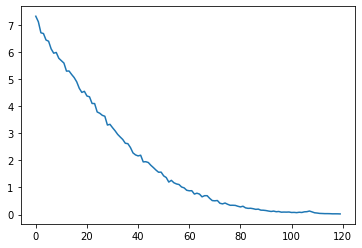

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()

In [31]:
torch.save(model.state_dict(),'model.pt')
from google.colab import files
files.download('model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
def prediction(x):
    for idx in x:
      if idx == 0:
        break
      print(English_vocab.idx2word[int(idx)],end=' ')
    
    print()

    x = x.long().reshape(1,-1).to(device)
    ans = translate(x)
    res = []
    for id in ans:
      res.append(Hindi_vocab.idx2word[id])
    
    return res


In [31]:
def translate(input):
      #input = batch of english sentences[batch, sentece(padded)]
      with torch.no_grad():
        guess = []
        encoder_states, hidden, cell = model.encoder(input)
        # x = torch.ones((1)).float().to(device) # <START> token
        x = torch.ones((1)).long().to(device)
        while True:
          out, hidden, cell = model.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
          x = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]
          guess.append(int(x[0].detach().cpu()))

          if x == 2:
            break

      return guess

In [32]:
prediction(dataset[50][0])

category information technology <END> 


['श्रेणी', 'सूचना', 'प्रौद्योगिकी', '<END>']

In [35]:
prediction(dataset[100][0])

class united states of america <END> 


['श्रेणी', 'संयुक्त', 'राज्य', 'अमेरिका', '<END>']

In [36]:
prediction(dataset[71][0])

he often spoke to us of his own great longing to meet him <END> 


['वे',
 'बहुधा',
 'उनसे',
 'मिलने',
 'की',
 'तीव्र',
 'इच्छा',
 'के',
 'बारे',
 'में',
 'भी',
 'हमें',
 'बताया',
 'करते',
 '<END>']

In [55]:
prediction(dataset[random.randint(0,10000)][0])

my mind works like google for images <END> 


['मेरा',
 'दिमाग',
 'गूगल',
 'की',
 'तरह',
 'काम',
 'करता',
 'है',
 'चित्रो',
 'के',
 'लिये',
 '<END>']

In [ ]:
for i in range(15):
  prediction(dataset[random.randint(0,10000)][0])

In [ ]:
dataset[3][0]

tensor([ 8., 30., 31., 32., 23., 33., 34., 35., 36., 37.,  4., 38., 39.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [33]:
def get(sent):
  # sentence = sentence.lower()
  # sent = sentence.split()
  # sent.append('<END>')
  # print(sent)

  toks = []
  for word in sent:
    if English_vocab.word2idx.get(word) is None:
      toks.append(English_vocab.word2idx['the'])
    else:
      toks.append(English_vocab.word2idx[word])
  # print(toks)
  sent = torch.tensor(toks).float()
  res = prediction(sent)
  # print(res)
  return res

In [40]:
#bleu score calculation

In [34]:
tdf = pd.read_csv('data.csv')
tdf.drop(columns=['source'],inplace=True)
tdf = tdf.iloc[10001:11000,:]
tdf.head()

,english_sentence,hindi_sentence
10001,AMF vechers calculated three mass medias in 20...,मोबाइल फोन पर मीडिया के आगमन से अल्फा उपयोगकर्...
10002,Ask if any check has been made .,पता कीजिए कि क्या कोई जाँच हुई है .
10003,for eight billion people living in cities,ऐसे शहरों में रहने वाले ८ अरब लोगों को
10004,"He had an idea, a very clear idea.","उनका विचार था, एकदम साफ विचार,"
10005,Government should make documents related to Ne...,नेताजी से जुड़े दस्तावेज सार्वजनिक करे सरकार


In [35]:
tdf.iloc[:,0] = tdf['english_sentence'].apply(func=cleanerEng)
tdf.iloc[:,1] = tdf['hindi_sentence'].apply(func= cleanerHindi)
tdf.iloc[:,0] = tdf['english_sentence'].apply(func= lambda x : (str(x).split()))
tdf.iloc[:,1] = tdf['hindi_sentence'].apply(func= lambda x : (str(x).split()))

In [36]:
tdf.head()

,english_sentence,hindi_sentence
10001,"[amf, vechers, calculated, three, mass, medias...","[मोबाइल, फोन, पर, मीडिया, के, आगमन, से, अल्फा,..."
10002,"[ask, if, any, check, has, been, made]","[पता, कीजिए, कि, क्या, कोई, जाँच, हुई, है]"
10003,"[for, eight, billion, people, living, in, cities]","[ऐसे, शहरों, में, रहने, वाले, ८, अरब, लोगों, को]"
10004,"[he, had, an, idea, a, very, clear, idea]","[उनका, विचार, था, एकदम, साफ, विचार]"
10005,"[government, should, make, documents, related,...","[नेताजी, से, जुड़े, दस्तावेज, सार्वजनिक, करे, ..."


In [37]:
tdf.iloc[:,0] = tdf['english_sentence'].apply(func= addTokens,start=False)

In [38]:
tdf.head()

,english_sentence,hindi_sentence
10001,"[amf, vechers, calculated, three, mass, medias...","[मोबाइल, फोन, पर, मीडिया, के, आगमन, से, अल्फा,..."
10002,"[ask, if, any, check, has, been, made, <END>]","[पता, कीजिए, कि, क्या, कोई, जाँच, हुई, है]"
10003,"[for, eight, billion, people, living, in, citi...","[ऐसे, शहरों, में, रहने, वाले, ८, अरब, लोगों, को]"
10004,"[he, had, an, idea, a, very, clear, idea, <END>]","[उनका, विचार, था, एकदम, साफ, विचार]"
10005,"[government, should, make, documents, related,...","[नेताजी, से, जुड़े, दस्तावेज, सार्वजनिक, करे, ..."


In [39]:
tdata = tdf.values
test_dataset = vocab(tdata[:,0],token=False)

In [44]:
res = get(tdata[157,0])[:-1]
print(res)
print(tdata[157,0][:-1])

new front of al the the next january 2005 9 11 in after attack the transfer the report to europe and which are is part of the network of the <END> 
['कई', 'बार', 'जब', 'दो', 'अन्य', 'स्थानीय', 'सितंबर', 'मंदिरों', 'की', 'योजना', 'का', 'एक', 'नया', 'अधिकार', 'आता', 'है', 'की', 'इस', 'नदी', 'के', 'मामले', 'में', 'नेपाल', 'के', 'बाद', 'लगभग', '300', 'किलोग्राम', 'देना', 'पड़ा', 'जिसे', 'जैसा', 'की', 'एक']
['new', 'front', 'of', 'al', 'kayada', 'pbs', 'next', 'january', '2005', '9', '11', 'in', 'after', 'attack', 'argent', 'transfer', 'the', 'report', 'to', 'europe', 'and', 'which', 'are', 'is', 'part', 'of', 'the', 'network', 'of', 'zealot']


In [ ]:
list_refrences = []
list_hypothesis = []
for i in tqdm(range(int(tdata.shape[0]/2))):
  list_refrences.append(tdata[i,0][:-1])
  list_hypothesis.append((get(tdata[i,0])[:-1]))

In [51]:
import nltk
print(f"bleu-1 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(1.0,0.0,0.0,0.0))}")
print(f"bleu-2 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(0.5,0.5,0.0))}")
print(f"bleu-3 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(0.33,0.33,0.33,0.0))}")
print(f"bleu-4 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(0.25,0.25,0.25,0.25))}")

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


bleu-1 : 0.0005301664722722937
bleu-2 : 0.023025344129291397
bleu-3 : 0.08299578665255793
bleu-4 : 0.15174104299526675


In [ ]:
print(bleu_score)

0.1568784290294323
